In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import rankdata, pearsonr, spearmanr
import upsetplot
from IPython.display import display
from itertools import combinations
from statsmodels.stats.multitest import multipletests

In [2]:
def process_df(df:pd.DataFrame, drop_APOE:bool=True):
    summ_df = df.copy()
    summ_df['Gene'] = summ_df['Gene'].apply(lambda x: x.split('_')[0]).values
    summ_df.sort_values(['Gene', 'Acc'], ascending=[True, False], inplace=True)
    summ_df.drop_duplicates('Gene', inplace=True)
    if drop_APOE:
        summ_df = summ_df.loc[~summ_df['Gene'].isin(['APOE', 'TOMM40', 'APOC1', 'BCAM'])]
    if 'P' in df.columns:
        summ_df['-logP'] = -np.log10(summ_df['P'])
        summ_df['Rank'] = rankdata(summ_df['P'])
    return summ_df

In [54]:
metric = 'Loss'

## Sensitivity vs GWANNv1

In [33]:
for s in ['1.4']:
# for s in ['1.3', '1.4', '1.5', '1.6']:
    if s != '1.4':
        summ_df_new = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_Sens{s}/MATERNAL_MARIONI_Sens{s}_summary.csv')
    else:
        summ_df_new = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_Sens{s}/1_MATERNAL_MARIONI_Sens{s}_summary.csv')
    summ_df_new = process_df(summ_df_new)
    summ_df_v1 = pd.read_csv('../../GWASOnSteroids/Results/Annotated_NoDup_MatAD_NN_GWAS.csv')
    summ_df_v1 = process_df(summ_df_v1)
    summ_df_v1.set_index('Gene', inplace=True, drop=False)
    summ_df_v1 = summ_df_v1.loc[summ_df_new['Gene'].values]

    x = summ_df_new[f'{metric}'].values
    y = summ_df_v1[f'{metric}'].values
    sns.regplot(x=x, y=y, ci=None)
    if metric == '-logP':
        plt.axvline(x=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
        plt.axhline(y=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
    plt.xlabel(f'{metric} when using dosage (Sens{s})')
    plt.ylabel(f'{metric} when using hardcall (-1 as missing)')
    plt.savefig(f'./results_Sens{s}/dosage_vs_hardcall_{metric}.png', dpi=100)
    plt.close()

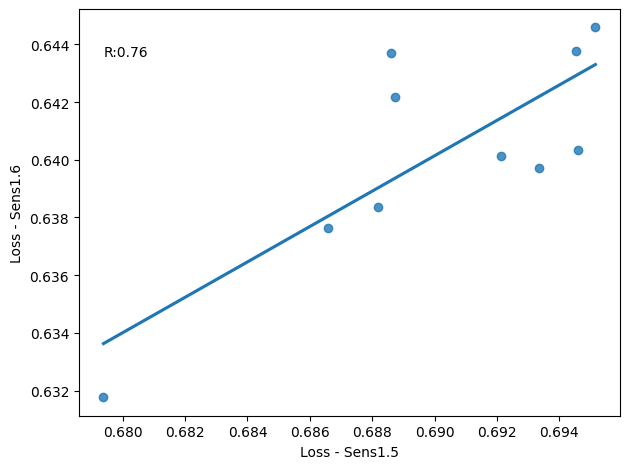

In [55]:
a = 'Sens1.5'
b = 'Sens1.6'
summ_df_a = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_{a}/MATERNAL_MARIONI_{a}_summary.csv')
summ_df_a = process_df(summ_df_a)

summ_df_b = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_{b}/MATERNAL_MARIONI_{b}_summary.csv')
summ_df_b = process_df(summ_df_b)
summ_df_b.set_index('Gene', inplace=True, drop=False)
summ_df_b = summ_df_b.loc[summ_df_a['Gene']]

x = summ_df_a[f'{metric}'].values
y = summ_df_b[f'{metric}'].values
r, p = spearmanr(x, y)
sns.regplot(x=x, y=y, ci=False)
plt.text(x=np.min(x), y=np.max(y)-0.001, s=f'R:{r:.2f}')
if metric == '-logP':
    plt.axvline(x=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
    plt.axhline(y=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
plt.xlabel(f'{metric} - {a}')
plt.ylabel(f'{metric} - {b}')

plt.tight_layout()
plt.savefig(f'./results_{a}/{a}_vs_{b}_{metric}.png', dpi=100)


## Sens 1.4

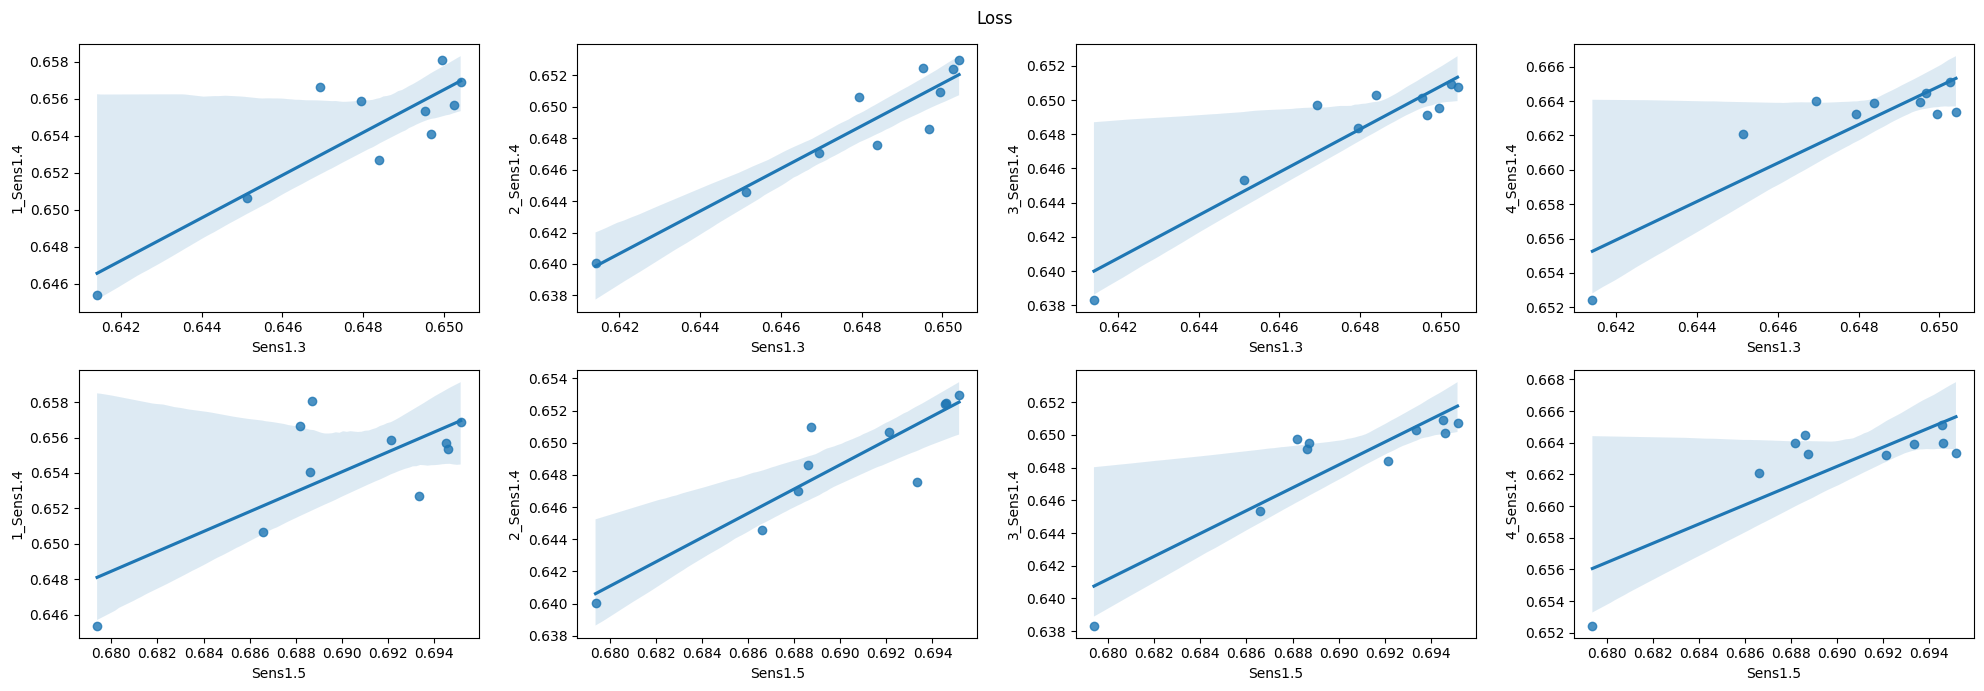

In [10]:
fig, ax = plt.subplots(2, 4, figsize=(20, 7))
ax = ax.flatten()
axi = 0
for sens in ['Sens1.3', 'Sens1.5']:
    for grouping in [1, 2, 3, 4]:
        summ_df_14 = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_Sens1.4/{grouping}_MATERNAL_MARIONI_Sens1.4_summary.csv')
        summ_df_14 = process_df(summ_df_14)
        summ_df_1x = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_{sens}/MATERNAL_MARIONI_{sens}_summary.csv')
        summ_df_1x = process_df(summ_df_1x)
        summ_df_1x.set_index('Gene', inplace=True, drop=False)
        summ_df_1x = summ_df_1x.loc[summ_df_14['Gene']]

        x = summ_df_1x[f'{metric}'].values
        y = summ_df_14[f'{metric}'].values
        # sns.scatterplot(x=x, y=y, ax=ax[axi])
        sns.regplot(x=x, y=y, ax=ax[axi])
        if metric == '-logP':
            ax[axi].axvline(x=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
            ax[axi].axhline(y=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
        ax[axi].set_xlabel(f'{sens}')
        ax[axi].set_ylabel(f'{grouping}_Sens1.4')
        
        axi += 1

fig.suptitle(metric)
fig.tight_layout()
fig.savefig(f'./results_Sens1.4/Sens1.4_vs_Sens1x_{metric}.png', dpi=100)


In [26]:
agg_summ_df = pd.DataFrame(columns=['Gene', 'Acc', 'Loss', '-logP', 'Rank', 'Grouping_id'])
for i in range(1, 5):
    for j in range(i+1, 5):
        dfi = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_Sens1.4/{i}_MATERNAL_MARIONI_Sens1.4_summary.csv')
        dfi = process_df(dfi)
        dfj = pd.read_csv(f'/home/upamanyu/GWANN/Code_AD/results_Sens1.4/{j}_MATERNAL_MARIONI_Sens1.4_summary.csv')
        dfj = process_df(dfj)
        
        x = dfi[f'{metric}'].values
        y = dfj[f'{metric}'].values

        sns.regplot(x=x, y=y)
        if metric == '-logP':
            plt.axvline(x=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
            plt.axhline(y=-np.log10(0.05/73310), linestyle=':', linewidth=1, color='r')
        plt.savefig(f'./results_Sens1.4/effect_of_diff_grouping/{i}vs{j}_{metric}.png', dpi=100)
        plt.close()


## Sens2

In [55]:
grp_sizes = [5, 10, 15, 20]
rand_seeds = [82, 192, 8376, 1763]
for label in ['MATERNAL_MARIONI']:
    grp_summ_df = []
    for grp_size in grp_sizes:
        for si, seed in enumerate(rand_seeds):
            exp_name = f'Sens2_{si}_{grp_size}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            summ_df = pd.read_csv(exp_summ_path)
            summ_df = process_df(summ_df)
            summ_df['Group_size'] = grp_size
            summ_df['Random_seed'] = seed
            summ_df = summ_df[['Group_size', 'Random_seed', 'Gene', 'Acc', 'Loss']]
            grp_summ_df.append(summ_df)
    grp_summ_df = pd.concat(grp_summ_df)

In [56]:
for met in ['Loss', 'Acc']:
    sns.displot(data=grp_summ_df, col='Group_size', x=met, hue='Random_seed', 
                kind='kde', palette='flare', hue_order=rand_seeds)
    plt.savefig(f'./results_Sens2/Diff_groupings_{met}.png', dpi=100)
    plt.close()

In [57]:
metric = 'Acc'
for grp_size in grp_sizes:
    fig, ax = plt.subplots(3, 3, figsize=(15, 10))
    for j in range(len(rand_seeds)):
        exp_name = f'Sens2_{j}_{grp_size}'
        exp_summ_path = (f'NN_Logs/'+
            f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
            f'{label}_Chr{exp_name}_2500bp_summary.csv')
        dfj = pd.read_csv(exp_summ_path)
        dfj = process_df(dfj)

        for k in range(j+1, len(rand_seeds)):
            exp_name = f'Sens2_{k}_{grp_size}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            dfk = pd.read_csv(exp_summ_path)
            dfk = process_df(dfk)

            x = dfj[metric].values
            y = dfk[metric].values
            r, p = spearmanr(x, y)
            sns.regplot(x=x, y=y, ci=False, ax=ax[k-1][j])
            # ax[k-1][j].text(x=0.5, y=0.5, s=f'R:{r}\nP:{p}')
            ax[k-1][j].text(x=np.min(x), y=np.max(y)-0.001, s=f'R:{r:.2f}')

    fig.tight_layout()
    fig.savefig(f'./results_Sens2/Grp_size{grp_size}_{metric}.png', dpi=100)
    plt.close()


## Sens3

In [73]:
grp_sizes = [5, 10, 15, 20, 25, 30]
sens_types = ['Sens2', 'Sens2', 'Sens2', 'Sens3', 'Sens3', 'Sens3']
rand_seeds = [82, 192, 8376, 1763]

In [74]:
for label in ['MATERNAL_MARIONI']:
    grp_summ_df = []
    for sens_type, grp_size in zip(sens_types, grp_sizes):
        for si, seed in enumerate(rand_seeds):
            exp_name = f'{sens_type}_{si}_{grp_size}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            summ_df = pd.read_csv(exp_summ_path)
            summ_df = process_df(summ_df)
            summ_df['Group_size'] = grp_size
            summ_df['Random_seed'] = seed
            summ_df = summ_df[['Group_size', 'Random_seed', 'Gene', 'Acc', 'Loss']]
            grp_summ_df.append(summ_df)
    grp_summ_df = pd.concat(grp_summ_df)

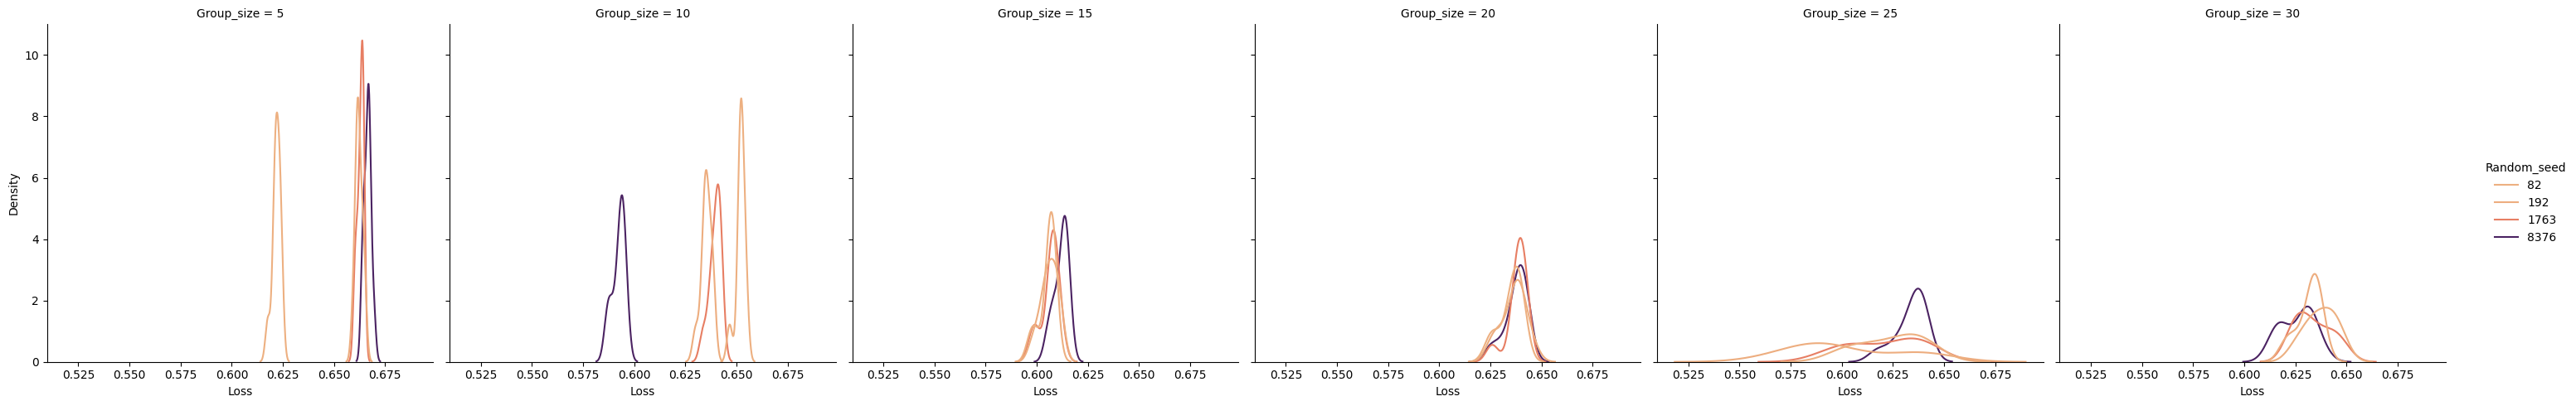

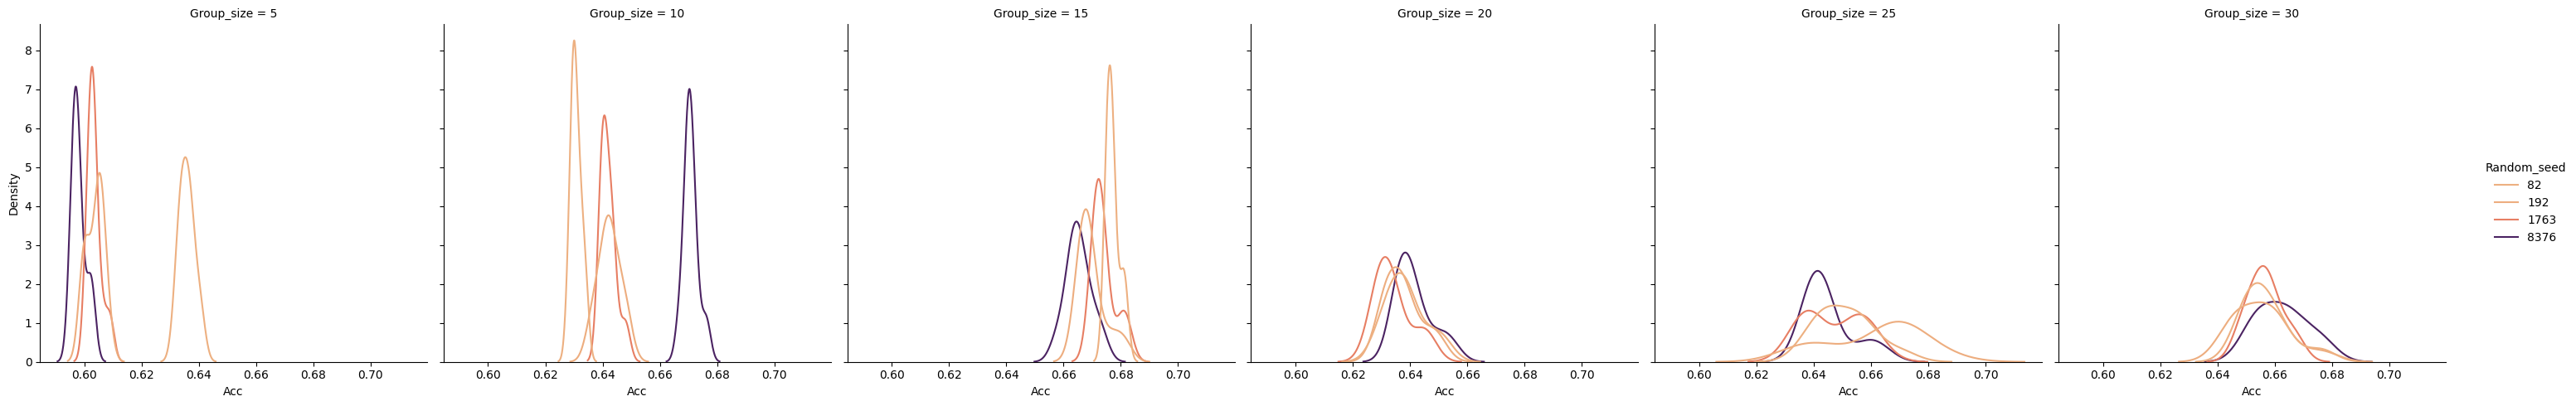

In [76]:
for met in ['Loss', 'Acc']:
    sns.displot(data=grp_summ_df, col='Group_size', x=met, hue='Random_seed', 
                kind='kde', palette='flare', hue_order=rand_seeds)
    plt.savefig(f'./results_Sens3/Diff_groupings_{met}.png', dpi=100)

In [77]:
corr_fn = pearsonr
corr_dict = {'Group_size':[], 'Rand_seed_pair':[], corr_fn.__name__:[], 'Metric':[]}
for sens_type, grp_size in zip(sens_types, grp_sizes):
    for j in range(len(rand_seeds)):
        exp_name = f'{sens_type}_{j}_{grp_size}'
        exp_summ_path = (f'NN_Logs/'+
            f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
            f'{label}_Chr{exp_name}_2500bp_summary.csv')
        dfj = pd.read_csv(exp_summ_path)
        dfj = process_df(dfj)

        for k in range(j+1, len(rand_seeds)):
            exp_name = f'{sens_type}_{k}_{grp_size}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            dfk = pd.read_csv(exp_summ_path)
            dfk = process_df(dfk)

            for metric in ['Acc', 'Loss']:
                x = dfj[metric].values
                y = dfk[metric].values
                r, p = corr_fn(x, y)
                corr_dict['Group_size'].append(grp_size)
                corr_dict['Rand_seed_pair'].append(f'{j}_{k}')
                corr_dict[corr_fn.__name__].append(r)
                corr_dict['Metric'].append(metric)
corr_df = pd.DataFrame.from_dict(corr_dict)


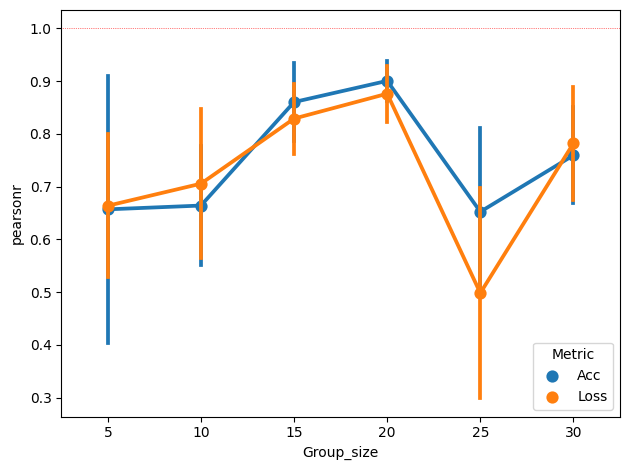

In [78]:
sns.pointplot(data=corr_df, x='Group_size', y=corr_fn.__name__, hue='Metric', 
              errorbar='sd')
plt.axhline(y=1, xmin=0, xmax=1, linestyle=':', c='r', linewidth='0.5')
plt.tight_layout()
plt.savefig(f'./results_Sens3/Diff_groupings_{corr_fn.__name__}.png', dpi=100)

## Sens4

In [40]:
oversample = [5, 10, 15, 20]
sens_types = ['Sens4', 'Sens4', 'Sens4', 'Sens3']
rand_seeds = [82, 192, 8376, 1763]
grp_size = 20

In [41]:
for label in ['MATERNAL_MARIONI']:
    grp_summ_df = []
    for sens_type, ovs in zip(sens_types, oversample):
        for si, seed in enumerate(rand_seeds):
            exp_name = f'{sens_type}_{si}_{ovs}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            summ_df = pd.read_csv(exp_summ_path)
            summ_df = process_df(summ_df)
            summ_df['Group_size'] = grp_size
            summ_df['Oversample'] = ovs
            summ_df['Random_seed'] = seed
            summ_df = summ_df[['Group_size', 'Oversample', 'Random_seed', 'Gene', 'Acc', 'Loss']]
            grp_summ_df.append(summ_df)
    grp_summ_df = pd.concat(grp_summ_df)

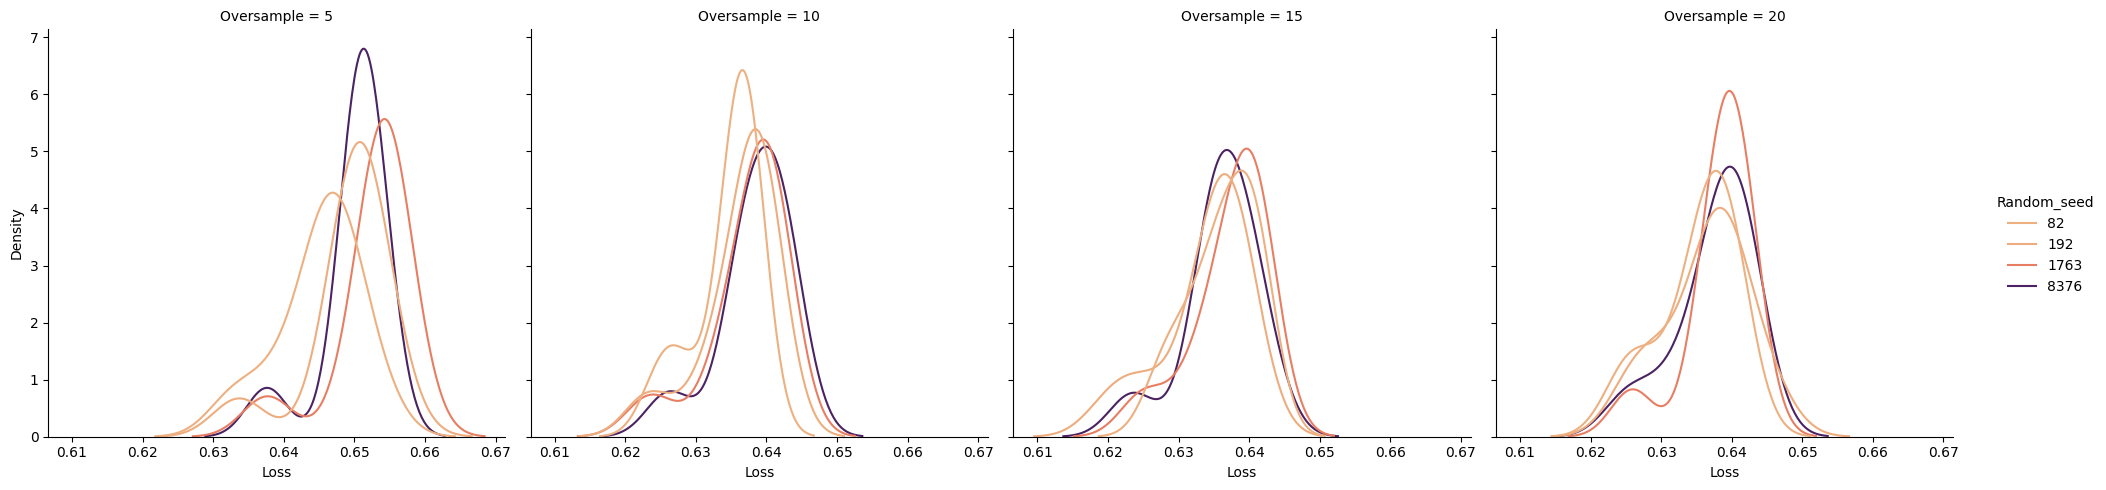

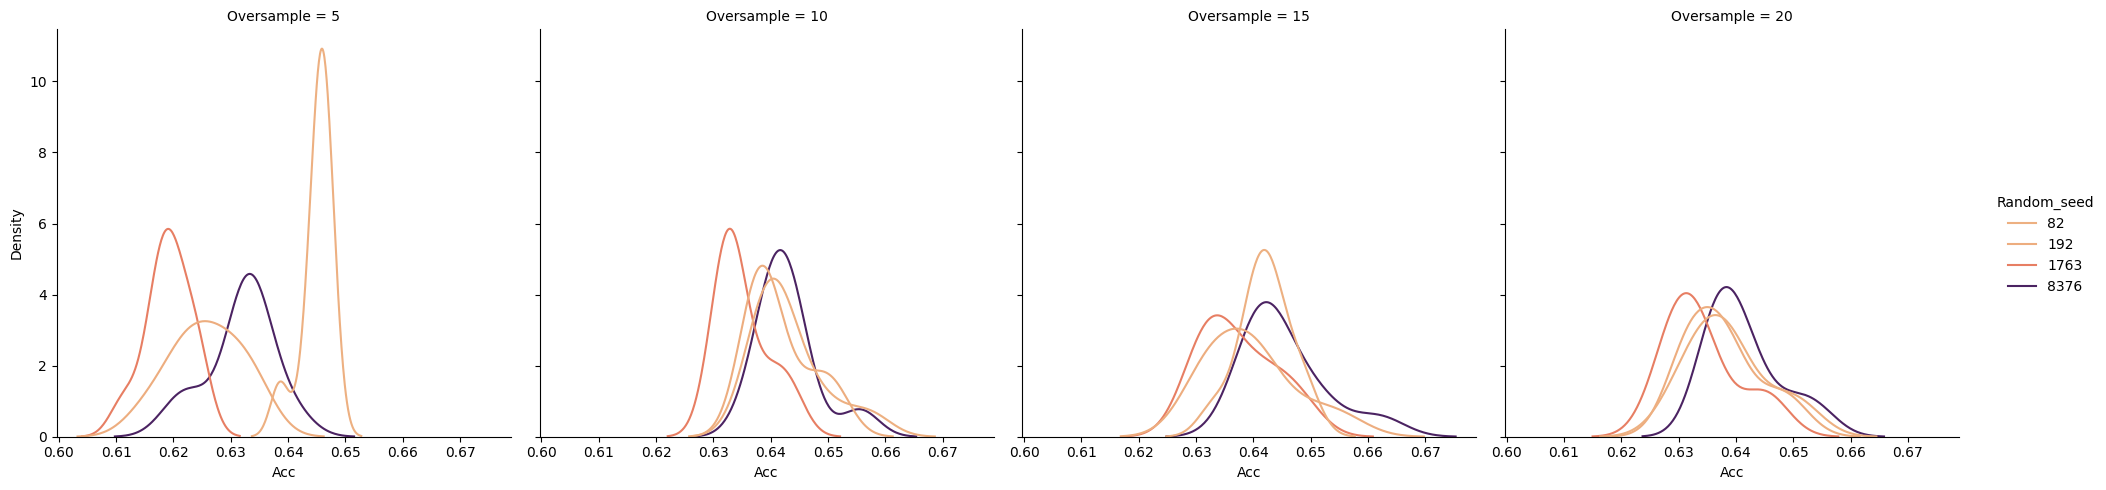

In [42]:
for met in ['Loss', 'Acc']:
    sns.displot(data=grp_summ_df, col='Oversample', x=met, hue='Random_seed', 
                kind='kde', palette='flare', hue_order=rand_seeds)
    plt.savefig(f'./results_Sens4/Diff_groupings_{met}.png', dpi=100)

In [43]:
corr_fn = spearmanr
corr_dict = {'Oversample':[], 'Rand_seed_pair':[], corr_fn.__name__:[], 'Metric':[]}
for sens_type, ovs in zip(sens_types, oversample):
    for j in range(len(rand_seeds)):
        exp_name = f'{sens_type}_{j}_{ovs}'
        exp_summ_path = (f'NN_Logs/'+
            f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
            f'{label}_Chr{exp_name}_2500bp_summary.csv')
        dfj = pd.read_csv(exp_summ_path)
        dfj = process_df(dfj)

        for k in range(j+1, len(rand_seeds)):
            exp_name = f'{sens_type}_{k}_{ovs}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            dfk = pd.read_csv(exp_summ_path)
            dfk = process_df(dfk)

            for metric in ['Acc', 'Loss']:
                x = dfj[metric].values
                y = dfk[metric].values
                r, p = corr_fn(x, y)
                corr_dict['Oversample'].append(ovs)
                corr_dict['Rand_seed_pair'].append(f'{j}_{k}')
                corr_dict[corr_fn.__name__].append(r)
                corr_dict['Metric'].append(metric)
corr_df = pd.DataFrame.from_dict(corr_dict)


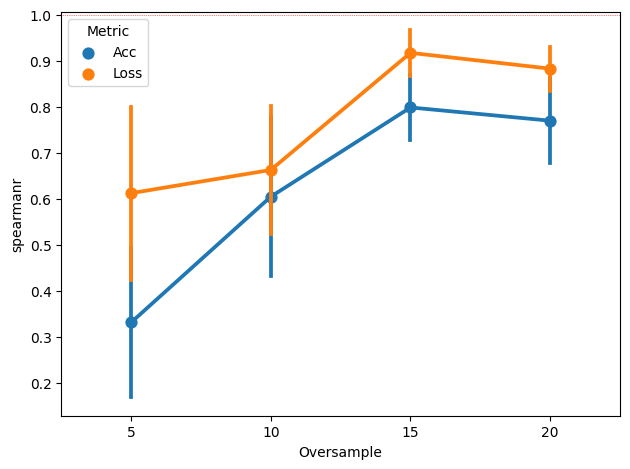

In [44]:
sns.pointplot(data=corr_df, x='Oversample', y=corr_fn.__name__, hue='Metric', 
              errorbar='sd')
plt.axhline(y=1, xmin=0, xmax=1, linestyle=':', c='r', linewidth='0.5')
plt.tight_layout()
plt.savefig(f'./results_Sens4/Diff_groupings_{corr_fn.__name__}.png', dpi=100)

### Effect of balancing batches 1:1 case:control

In [10]:
oversample = [10, 15]
batches = {'Sens4':'random', 'Sens4.1':'balanced'}
rand_seeds = [82, 192, 8376, 1763]
grp_size = 20
corr_fn = pearsonr
corr_dict = {'Rand_seed':[], corr_fn.__name__:[], 'Metric':[]}
label = 'MATERNAL_MARIONI'

for ovs in oversample:
    for j in range(len(rand_seeds)):
        exp_name = f'Sens4_{j}_{ovs}'
        exp_summ_path = (f'NN_Logs/'+
            f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
            f'{label}_Chr{exp_name}_2500bp_summary.csv')
        dfj = pd.read_csv(exp_summ_path)
        dfj = process_df(dfj)

        exp_name = f'Sens4.1_{j}_{ovs}'
        exp_summ_path = (f'NN_Logs/'+
            f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
            f'{label}_Chr{exp_name}_2500bp_summary.csv')
        dfk = pd.read_csv(exp_summ_path)
        dfk = process_df(dfk)

        for metric in ['Acc', 'Loss']:
            x = dfj[metric].values
            y = dfk[metric].values
            r, p = corr_fn(x, y)
            corr_dict['Rand_seed'].append(j)
            corr_dict[corr_fn.__name__].append(r)
            corr_dict['Metric'].append(metric)
corr_df = pd.DataFrame.from_dict(corr_dict)


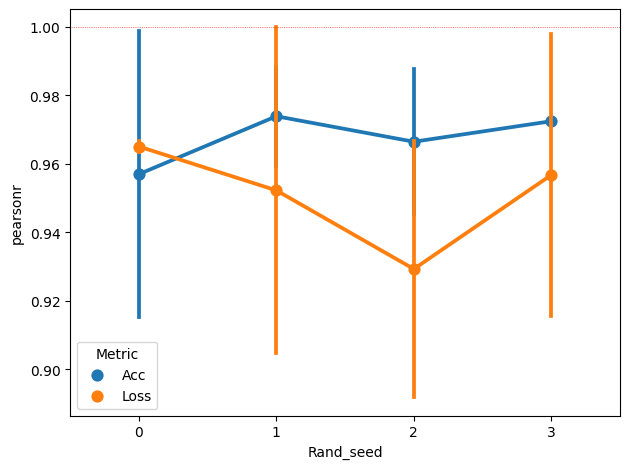

In [11]:
sns.pointplot(data=corr_df, x='Rand_seed', y=corr_fn.__name__, hue='Metric', 
              errorbar='sd')
plt.axhline(y=1, xmin=0, xmax=1, linestyle=':', c='r', linewidth='0.5')
plt.tight_layout()
plt.savefig(f'./results_Sens4/Diff_batch_type_{corr_fn.__name__}.png', dpi=100)

## Sens5

In [94]:
oversample = [15, 20]
sens_types = ['Sens5', 'Sens5']
rand_seeds = [82, 192, 8376, 1763]
grp_size = 20

In [95]:
for label in ['MATERNAL_MARIONI']:
    grp_summ_df = []
    for sens_type, ovs in zip(sens_types, oversample):
        for si, seed in enumerate(rand_seeds):
            exp_name = f'{sens_type}_{si}_{ovs}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            summ_df = pd.read_csv(exp_summ_path)
            summ_df = process_df(summ_df)
            summ_df['Group_size'] = grp_size
            summ_df['Oversample'] = ovs
            summ_df['Random_seed'] = seed
            summ_df = summ_df[['Group_size', 'Oversample', 'Random_seed', 'Gene', 'Acc', 'Loss']]
            grp_summ_df.append(summ_df)
    grp_summ_df = pd.concat(grp_summ_df)

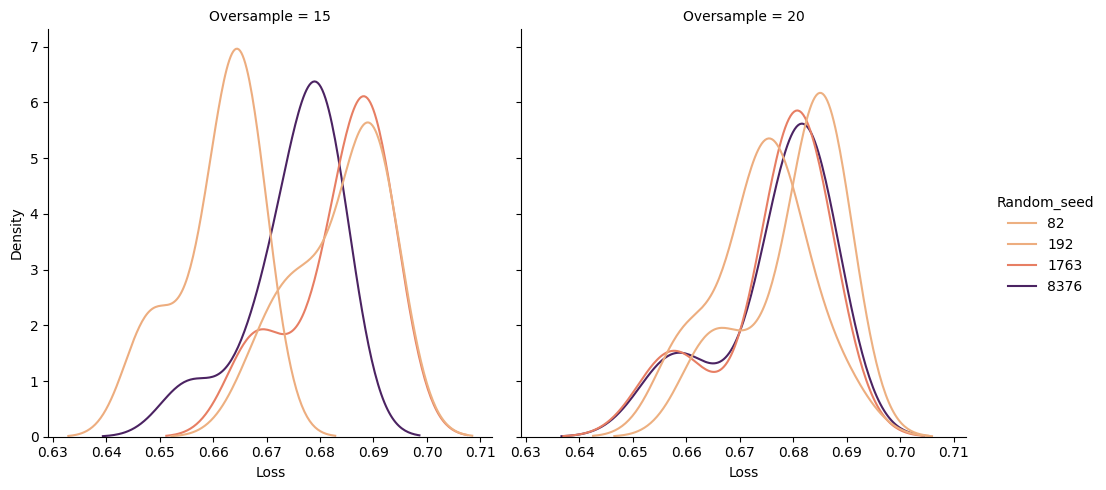

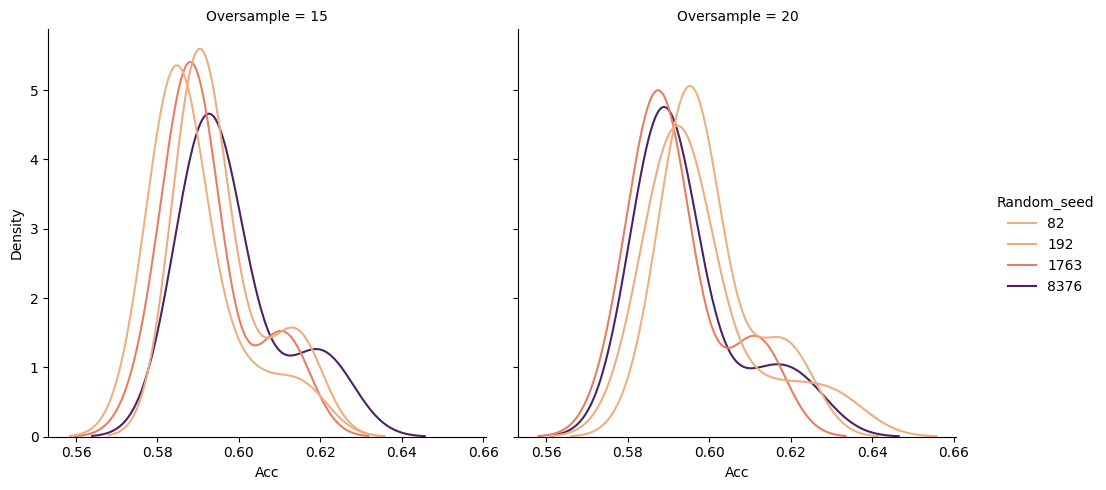

In [96]:
for met in ['Loss', 'Acc']:
    sns.displot(data=grp_summ_df, col='Oversample', x=met, hue='Random_seed', 
                kind='kde', palette='flare', hue_order=rand_seeds)
    plt.savefig(f'./results_Sens5/Diff_groupings_{met}.png', dpi=100)

In [97]:
corr_fn = pearsonr
corr_dict = {'Oversample':[], 'Rand_seed_pair':[], corr_fn.__name__:[], 'Metric':[]}
for sens_type, ovs in zip(sens_types, oversample):
    for j in range(len(rand_seeds)):
        exp_name = f'{sens_type}_{j}_{ovs}'
        exp_summ_path = (f'NN_Logs/'+
            f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
            f'{label}_Chr{exp_name}_2500bp_summary.csv')
        dfj = pd.read_csv(exp_summ_path)
        dfj = process_df(dfj)

        for k in range(j+1, len(rand_seeds)):
            exp_name = f'{sens_type}_{k}_{ovs}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            dfk = pd.read_csv(exp_summ_path)
            dfk = process_df(dfk)

            for metric in ['Acc', 'Loss']:
                x = dfj[metric].values
                y = dfk[metric].values
                r, p = corr_fn(x, y)
                corr_dict['Oversample'].append(ovs)
                corr_dict['Rand_seed_pair'].append(f'{j}_{k}')
                corr_dict[corr_fn.__name__].append(r)
                corr_dict['Metric'].append(metric)
corr_df = pd.DataFrame.from_dict(corr_dict)


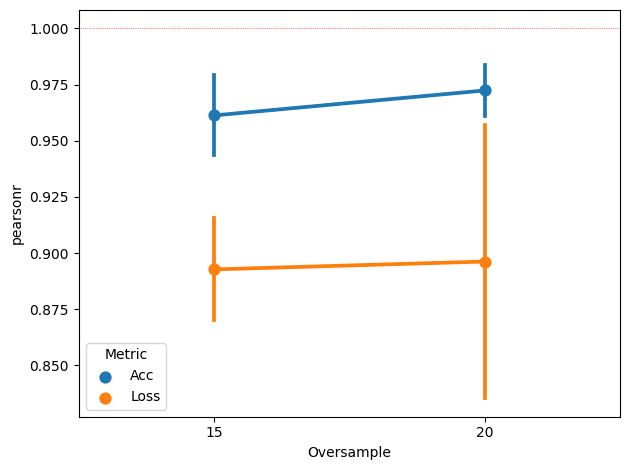

In [98]:
sns.pointplot(data=corr_df, x='Oversample', y=corr_fn.__name__, hue='Metric', 
              errorbar='sd')
plt.axhline(y=1, xmin=0, xmax=1, linestyle=':', c='r', linewidth='0.5')
plt.tight_layout()
plt.savefig(f'./results_Sens5/Diff_groupings_{corr_fn.__name__}.png', dpi=100)

### Sens4 vs Sens5

In [99]:
oversample = [15, 20, 15, 20]
sens_types = ['Sens5', 'Sens5', 'Sens4.1', 'Sens3']
rand_seeds = [82, 192, 8376, 1763]
grp_size = 20

In [101]:
for label in ['MATERNAL_MARIONI']:
    grp_summ_df = []
    for sens_type, ovs in zip(sens_types, oversample):
        for si, seed in enumerate(rand_seeds):
            exp_name = f'{sens_type}_{si}_{ovs}'
            exp_summ_path = (f'NN_Logs/'+
                f'{label}_Chr{exp_name}_GWANNet5_[128,64]_Dr_0.3_LR:0.0001_BS:256_Optim:adam/'+
                f'{label}_Chr{exp_name}_2500bp_summary.csv')
            summ_df = pd.read_csv(exp_summ_path)
            summ_df = process_df(summ_df)
            summ_df['Group_size'] = grp_size
            summ_df['Oversample'] = ovs
            summ_df['Random_seed'] = seed
            summ_df['Sens'] = '1:5' if sens_type == 'Sens5' else '1:1'
            summ_df = summ_df[['Group_size', 'Oversample', 'Random_seed', 'Sens', 'Gene', 'Acc', 'Loss']]
            grp_summ_df.append(summ_df)
    grp_summ_df = pd.concat(grp_summ_df, ignore_index=True)

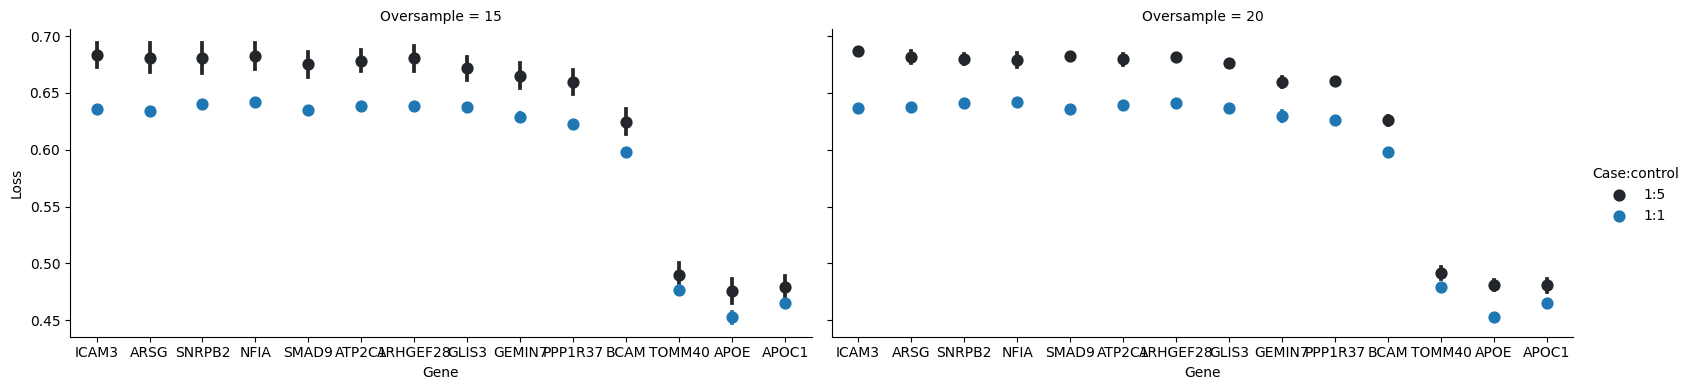

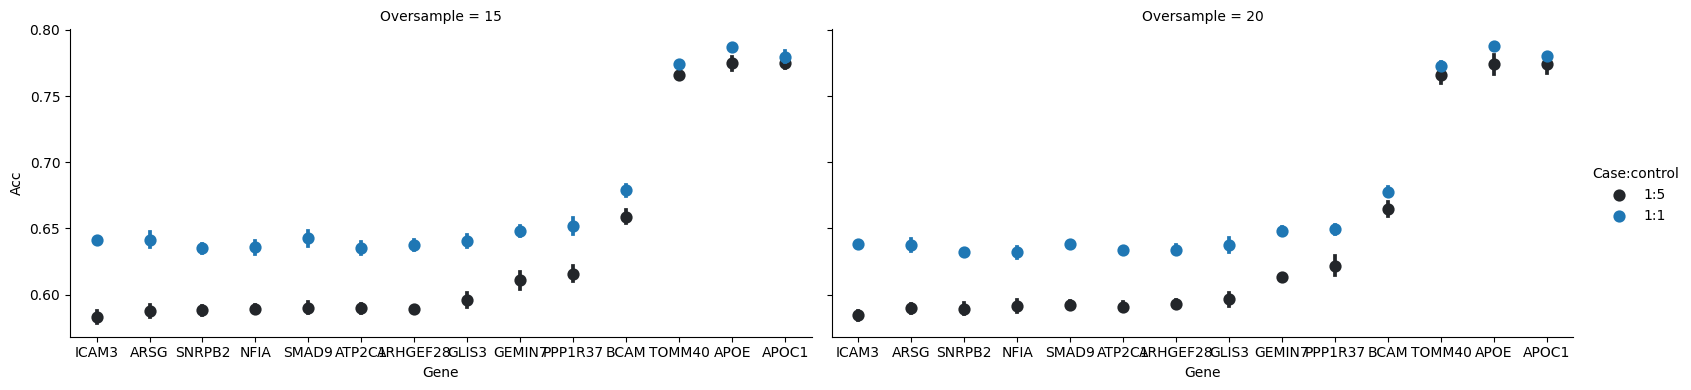

In [102]:
grp_summ_df.sort_values(['Acc', 'Gene', 'Sens'], inplace=True)
x_order = grp_summ_df.drop_duplicates('Gene')['Gene'].to_list()
for met in ['Loss', 'Acc']:
    fg = sns.FacetGrid(data=grp_summ_df, col='Oversample', 
                       col_order=np.unique(grp_summ_df['Oversample']), 
                       height=4, aspect=2, sharex=True, sharey=True)
    fg.map_dataframe(sns.pointplot, x='Gene', y=met, order=x_order, 
                     hue='Sens', errorbar='sd', join=False)
    fg.add_legend(title='Case:control')
    # sns.displot(data=grp_summ_df, col='Oversample', x=met, hue='Random_seed', 
    #             kind='kde', palette='flare', hue_order=rand_seeds)
    # plt.savefig(f'./results_Sens5/Diff_case_control_ratio_{met}.png', dpi=100)

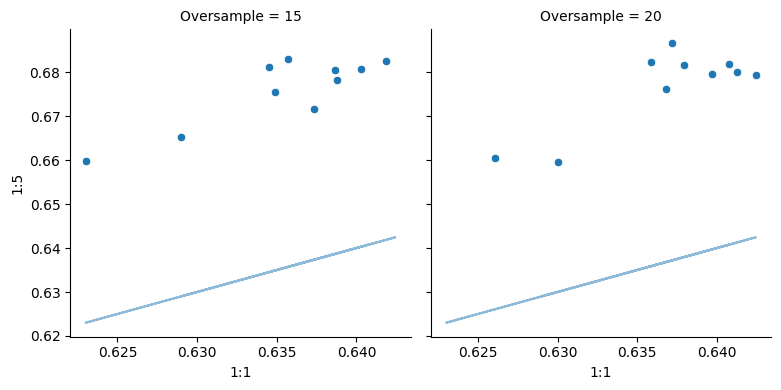

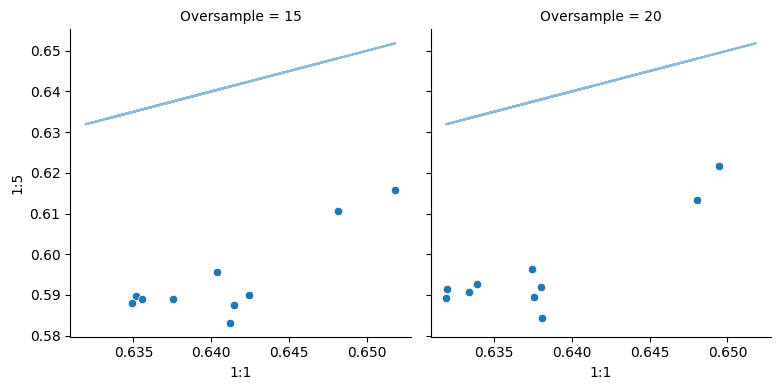

In [93]:
for met in ['Loss', 'Acc']:
    df = grp_summ_df.groupby(['Gene', 'Oversample', 'Sens']).mean(numeric_only=True).reset_index()
    df = pd.pivot(data=df, columns='Sens', values=met, index=['Gene', 'Oversample']).reset_index()
    
    fg = sns.FacetGrid(data=df, col='Oversample',
                       col_order=np.unique(grp_summ_df['Oversample']), 
                       height=4, aspect=1, sharex=True, sharey=True)
    fg.map_dataframe(sns.scatterplot, data=df, x='1:1', y='1:5')
    axes = fg.fig.axes
    x = df['1:1'].values
    y = x
    for ax in axes:
        ax.plot(y, x, alpha=0.5)
    # lim = (min(grp_summ_df[met]), max(grp_summ_df[met]))
    # fg.set(xlim=lim, ylim=lim)

## Sens7 and Sens8


### Correlation plots

In [3]:
def corr_plots(comb_df, fig_size1=(8, 4), fig_size2=(8, 8)):
    cols = comb_df.columns
    fig1, axes = plt.subplots(1, 2, figsize=fig_size1)
    axes = axes.flatten()
    for i, func in enumerate(['pearson', 'spearman']):
        ax = axes[i]
        corr = comb_df.corr(func)
        np.fill_diagonal(corr.values, np.nan)
        
        corr = np.tril(corr.values)
        corr = np.where(corr != 0, corr, np.ones_like(corr)*np.nan)
        sns.heatmap(corr, 
                    xticklabels=cols,
                    yticklabels=cols,
                    cmap='Reds',
                    vmin=0, vmax=1,
                    annot=True,
                    linewidths=0.5,
                    ax=ax)
        ax.set_xlabel('{Torch}{Python}')
        ax.set_ylabel('{Torch}{Python}')
        ax.set_title(f'{func} heatmap')
    fig1.tight_layout()

    try:
        df = comb_df.drop(index=['APOE_0'])
    except:
        df = comb_df
    fig2, axes = plt.subplots(nrows=len(cols), ncols=len(cols), figsize=fig_size2)
    for i in range(0,len(cols)):
        for j in range(i+1,len(cols)):
            if i == j: 
                axes[i,j].axis('off')
            else:
                x = df[cols[i]]
                y = df[cols[j]]
                
                axes[j,i].scatter(x, y, s=2, alpha=0.15)
                axes[j,i].set_title(cols[j] + " vs " + cols[i])
    fig2.tight_layout()
    
    return (fig1, fig2)

### Non-smooth metric curves

In [60]:
grp_sizes = [10]
# tseeds = [8162, 918, 61, 1502, 163, 712, 4250, 0]
# rseeds = [8162, 918, 61, 1502, 163, 712, 4250, 0]
# tseeds = [163, 712, 4250, 0]
# rseeds = [163, 712, 4250, 0]
tseeds = [163, 712, 0]
rseeds = [163, 712, 0]
metric = 'Loss'
greater_is_better = False
version = 'v8'

In [3]:
comb_df = pd.DataFrame(columns=['Gene'])
for gs in grp_sizes:
    for tseed, rseed in zip(tseeds, rseeds):
        exp_name = f'Sens8_{tseed}{rseed}_GS{gs}_{version}'
        exp_folder = f'./NN_Logs/FH_AD_Chr{exp_name}_GWANNet5_[32,16]_Dr_0.5_LR:0.005_BS:256_Optim:adam'
        summ_df = pd.read_csv(f'{exp_folder}/FH_AD_Chr{exp_name}_2500bp_summary.csv')
        # summ_df = process_df(summ_df)
        summ_df.set_index('Gene', inplace=True)
        if len(comb_df) == 0:
            comb_df['Gene'] = summ_df.index.values
        comb_df[f'GS{gs}_{tseed}{rseed}'] = summ_df.loc[comb_df['Gene']][metric].values
comb_df.set_index('Gene', inplace=True)
comb_df = comb_df.loc[~ (comb_df.index.str.contains('APOE') | 
                            comb_df.index.str.contains('APOC1') | 
                            comb_df.index.str.contains('TOMM40') | 
                            comb_df.index.str.contains('BCAM')) ]

NameError: name 'grp_sizes' is not defined

In [ ]:
cols = [c for c in comb_df.columns]
fig1, fig2 = corr_plots(comb_df[cols], fig_size1=(15, 7))
# fig1.savefig('GS20_corr.png', dpi=200)
display(fig1)
plt.close()
plt.close()

### Different combinations of averaging r runs

In [62]:
for gs in grp_sizes:
    cols = [c for c in comb_df.columns if c.startswith(f'GS{gs}_')]
    print(cols)
    for r in [1, 3]:
        for ci in range(0, len(rseeds), r):
            c = cols[ci:ci+r]
            comb_df[f'GS{gs}_Avg{r}_{ci}'] = np.mean(comb_df[c].values, axis=1)
        
        # plot_cols = [c for c in comb_df.columns if c.startswith(f'GS{gs}_Avg{r}')]
        # fig1, fig2 = corr_plots(comb_df[plot_cols])
        # fig1.savefig(f'GS{gs}_Avg{r}_corr.png', dpi=200)
        # plt.close()
        # plt.close()
# for r in [2, 4, 8]:
#     plot_cols = [c for c in comb_df.columns if f'Avg{r}' in c]
#     fig1, fig2 = corr_plots(comb_df[plot_cols], fig_size1=(15, 7))
#     fig1.savefig(f'Avg{r}_corr.png', dpi=200)
#     plt.close()
#     plt.close()

comb_df.head()

['GS10_163163', 'GS10_712712', 'GS10_00']


,GS10_163163,GS10_712712,GS10_00,GS10_Avg1_0,GS10_Avg1_1,GS10_Avg1_2,GS10_Avg3_0
Gene,,,,,,,
ACOT12_4,0.693560,0.693342,0.693171,0.693560,0.693342,0.693171,0.693358
ABR_10,0.693617,0.694595,0.694031,0.693617,0.694595,0.694031,0.694081
ABR_8,0.693091,0.693421,0.693699,0.693091,0.693421,0.693699,0.693403
ABR_9,0.693653,0.693366,0.693691,0.693653,0.693366,0.693691,0.693570
ABR_3,0.693690,0.693180,0.693473,0.693690,0.693180,0.693473,0.693448


In [ ]:
fig1, fig2 = corr_plots(comb_df=comb_df[[c for c in comb_df.columns if f'Avg{r}' in c]])
display(fig1, fig2)
plt.close()
plt.close()

### Dummy data avg metric across runs

In [63]:
dummy_df = pd.DataFrame(columns=['Gene'])
for gs in grp_sizes:
    for tseed, rseed in zip(tseeds, rseeds):
        exp_name = f'DummySens8_{tseed}{rseed}_GS{gs}_{version}'
        exp_folder = f'./NN_Logs/FH_AD_Chr{exp_name}_GWANNet5_[32,16]_Dr_0.5_LR:0.005_BS:256_Optim:adam'
        summ_df = pd.read_csv(f'{exp_folder}/FH_AD_Chr{exp_name}_2500bp_summary.csv')
        summ_df.set_index('Gene', inplace=True)
        if len(dummy_df) == 0:
            dummy_df['Gene'] = summ_df.index.values
        dummy_df[f'GS{gs}_{tseed}{rseed}'] = summ_df.loc[dummy_df['Gene']][metric].values
dummy_df.set_index('Gene', inplace=True)

In [64]:
from post_hoc import EstimatePValue
for gs in grp_sizes:
    cols = [c for c in comb_df.columns if c.startswith(f'GS{gs}_')]
    for r in [1, 3]:
        for ci in range(0, len(rseeds), r):
            
            c = cols[ci:ci+r]
            
            sign = 1 if greater_is_better else -1

            dummy_df[f'GS{gs}_Avg{r}_{ci}'] = sign*np.mean(dummy_df[list(c)].values, axis=1)
            
            ep = EstimatePValue(null_accs=dummy_df[f'GS{gs}_Avg{r}_{ci}'].values, 
                                greater_is_better=greater_is_better)
            
            comb_df[f'GS{gs}_Avg{r}_{ci}_logP'] = -np.log10(comb_df[f'GS{gs}_Avg{r}_{ci}'].apply(lambda x: ep.estimate(sign*x)).values)

/home/upamanyu/.pyenv/versions/3.8.15/envs/GWANN/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1722: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
/tmp/ipykernel_8670/735692800.py:16: RuntimeWarning: divide by zero encountered in log10
  comb_df[f'GS{gs}_Avg{r}_{ci}_logP'] = -np.log10(comb_df[f'GS{gs}_Avg{r}_{ci}'].apply(lambda x: ep.estimate(sign*x)).values)


GS10_Avg1_0_logP 9
GS10_Avg1_1_logP 33
GS10_Avg1_2_logP 62

GS10_Avg3_0_logP 56



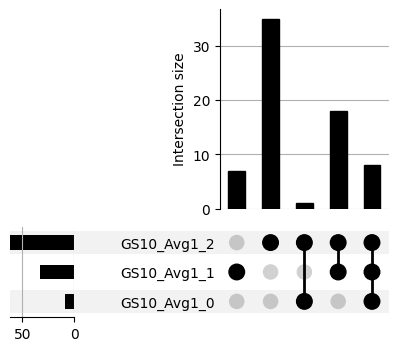

In [65]:
for r in [1, 3]:
    cols = [c for c in comb_df.columns if (f'Avg{r}' in c and c.endswith('logP'))]
    hit_dict = {}
    for key in cols:
        glist = comb_df.loc[comb_df[key] > -np.log10(7.05965407695023e-07)].index.values
        glist = set([g.split('_')[0] for g in glist])
        hit_dict[key.replace('_logP', '')] = glist
        print(key, len(glist))
    print()
    if len(cols) >= 2:
        upset_data = upsetplot.from_contents(hit_dict)
        up = upsetplot.plot(upset_data, include_empty_subsets=False, sort_categories_by='input')
        plt.savefig(f'Avg{r}_hit_overlap.png', dpi=200)

### Top K intersection

00: BIN1, PLCB1, ITPR3, PLCB4, ITPR2, APAF1, COX6A2, ATP2A2, CLU, COX8C
01: NDUFS1, ITPR3, BIN1, PLCB4, PPP3CA, GRIN2A, CLU, ITPR2, NDUFB10, ADAM17
10: PLCB4, COX4I2, GRIN2A, COX8C, COX6A1, GRIN2B, ITPR3, PLCB1, ITPR2, NDUFA4L2
11: BIN1, PLCB4, COX4I2, NDUFS1, COX7B2, ATP2A2, CLU, CYC1, LRP1, GRIN2B


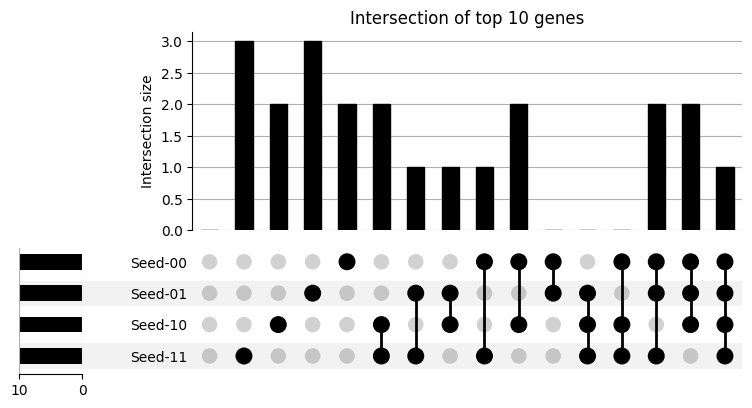

In [13]:
import upsetplot

for k in [10]:
    top_dict = {key:[] for key in comb_df.columns}
    for key in top_dict.keys():
        top_dict[key] = comb_df.sort_values(key, ascending=False).head(k).index.to_list()
        print(f'{key}: {", ".join(top_dict[key])}')
        top_dict[key] = set(top_dict[key])
    
    for key in list(top_dict.keys()):
        top_dict[f'Seed-{key}'] = top_dict.pop(key)

    upset_data = upsetplot.from_contents(top_dict)
    upsetplot.plot(upset_data, include_empty_subsets=True)
    plt.gca().set_title(f'Intersection of top {k} genes')
    # plt.savefig(f'./results_Sens7_00_GS10_v4/grp{grp_size}_top_{k}_upset.png')
    # plt.close()

### Correlation matrix

In [13]:
from IPython.display import display
fig1, fig2 = corr_plots(comb_df)
fig1.savefig(f'./results_Sens7_00_GS10_v4/grp{grp_size}_corr_heatmap_genes.png')
fig2.savefig(f'./results_Sens7_00_GS10_v4/grp{grp_size}_corr_scatter_genes.png')
plt.close()
plt.close()

### Smooth metric curves

In [8]:
import os
os.environ['TORCH_SEED'] = '0'
os.environ['GROUP_SEED'] = '1'
import sys
sys.path.append('..')
from GWANN.train_utils import metrics_from_conf_mat
import tqdm

def window_mean(X, w=5):
    X = np.concatenate((np.repeat(X[0], w//2), X, np.repeat(X[-1], w//2)))
    X_smooth = [] 
    for i in range(w//2, len(X)-w//2):
        window = X[i-w//2:i+w//2+1]
        window_average = np.mean(window)
        X_smooth.append(window_average)
        
    return X_smooth

grp_size = 10
comb_df = pd.DataFrame(columns=['Gene'])
for tseed, rseed in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    exp_name = f'Sens8_{tseed}{rseed}_GS{grp_size}_v4'
    exp_folder = f'/mnt/sdb/NN_Logs_archive/NN_Logs_Sens8/FH_AD_Chr{exp_name}_GWANNet5_[32,16]_Dr_0.5_LR:0.005_BS:256_Optim:adam'
    summ_df = pd.read_csv(f'{exp_folder}/FH_AD_Chr{exp_name}_2500bp_summary.csv')
    summ_df.set_index('Gene', drop=False, inplace=True)
    for g in tqdm.tqdm(summ_df.index.values):
        metrics = np.load(f'{exp_folder}/{g}/training_metrics.npz')
        train_loss = window_mean(metrics['agg_loss'][:, 0])
        test_loss = window_mean(metrics['agg_loss'][:, 1])
        train_acc = []
        test_acc = []
        for i, cm in enumerate(metrics['agg_conf_mat']):
            train_acc.append(metrics_from_conf_mat(cm[0])['acc'])
            test_acc.append(metrics_from_conf_mat(cm[1])['acc'])
        train_acc = window_mean(train_acc)
        test_acc = window_mean(test_acc)

        # met_df = pd.DataFrame(columns=['Epoch', 'Acc', 'Loss', 'Set'])
        # met_df['Epoch'] = np.tile(np.arange(len(train_acc)), 2)
        # met_df['Acc'] = np.concatenate((train_acc, test_acc))
        # met_df['Loss'] = np.concatenate((train_loss, test_loss))
        # met_df['Set'] = ['train']*len(train_acc) + ['test']*len(test_acc)

        # sns.lineplot(data=met_df, x='Epoch', y='Acc', style='Set', c='orange')
        # plt.savefig(f'{exp_folder}/{g}/smooth_acc.svg')
        # plt.close()

        # sns.lineplot(data=met_df, x='Epoch', y='Loss', style='Set', c='red')
        # plt.savefig(f'{exp_folder}/{g}/smooth_loss.svg')
        # plt.close()

        summ_df.loc[g, 'Loss'] = np.min(test_loss)
        summ_df.loc[g, 'Acc'] = test_acc[np.argmin(test_loss)]
        # summ_df.loc[g, 'Loss'] = test_loss[np.argmax(test_acc)]
        # summ_df.loc[g, 'Acc'] = np.max(test_acc)
    

    
    summ_df.reset_index(inplace=True, drop=True)
    summ_df = process_df(summ_df)
    summ_df.set_index('Gene', inplace=True)
    if len(comb_df) == 0:
        comb_df['Gene'] = summ_df.index.values
    comb_df[f'{tseed}{rseed}'] = summ_df.loc[comb_df['Gene']]['Acc'].values
comb_df.set_index('Gene', inplace=True)

  0%|          | 0/321 [00:00<?, ?it/s]


KeyError: 'agg_loss is not a file in the archive'

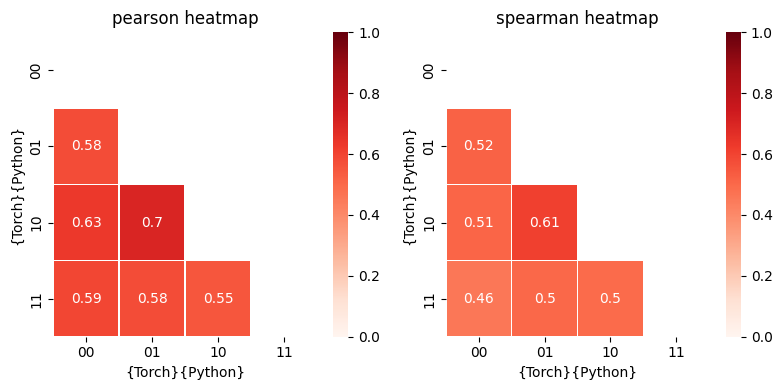

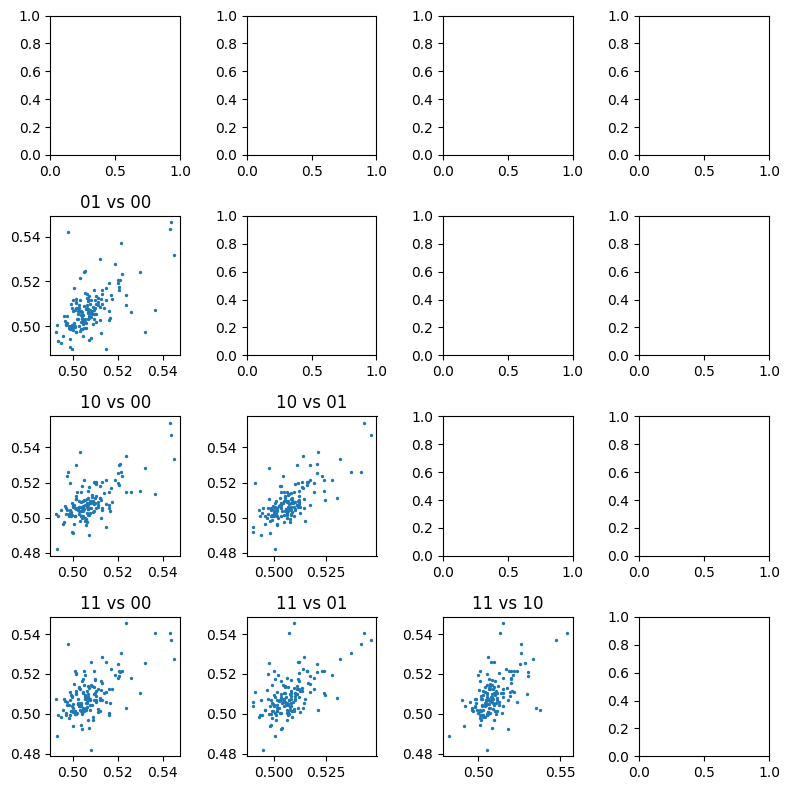

In [35]:
display(*corr_plots(comb_df))

### Correlation between group sizes

In [15]:
comb_df = pd.DataFrame(columns=['Gene'])
for grp_size in [10, 20]:
    for tseed, rseed in zip([0, 0, 1, 1], [0, 1, 0, 1]):
        exp_name = f'Sens7_{tseed}{rseed}_GS{grp_size}_v4'
        exp_folder = f'NN_Logs/FH_AD_Chr{exp_name}_GWANNet5_[32,16]_Dr_0.5_LR:0.005_BS:256_Optim:adam'
        summ_df = pd.read_csv(f'{exp_folder}/FH_AD_Chr{exp_name}_2500bp_summary.csv')
        summ_df = process_df(summ_df)
        summ_df.set_index('Gene', inplace=True)
        if len(comb_df) == 0:
            comb_df['Gene'] = summ_df.index.values
        comb_df[f'GS{grp_size}_{tseed}{rseed}'] = summ_df.loc[comb_df['Gene']]['Acc'].values
comb_df.set_index('Gene', inplace=True)

In [20]:
fig1, fig2 = corr_plots(comb_df, fig_size1=(16, 8), fig_size2=(16, 16))
fig1.savefig(f'./results_Sens7_00_GS10_v4/inter_grp_corr_heatmap_genes.png')
fig2.savefig(f'./results_Sens7_00_GS10_v4/inter_grp_corr_scatter_genes.png')
plt.close()
plt.close()

## Sens8 Stepped run

### Run1

In [84]:
grp_sizes = [10]
tseeds = [0, 712, 163]
rseeds = [0, 712, 163]
metric = 'Loss'
greater_is_better = False
version = 'v4'

comb_df = None
for gs in grp_sizes:
    for tseed, rseed in zip(tseeds, rseeds):
        exp_name = f'Sens8_{tseed}{rseed}_GS{gs}_{version}'
        exp_folder = f'./results_{exp_name}'
        summ_df = pd.read_csv(f'{exp_folder}/FH_AD_{metric}_{exp_name}_summary.csv')
        summ_df[f'GS{gs}_{tseed}{rseed}_P'] = summ_df['P'].values
        summ_df = summ_df[['Gene', f'GS{gs}_{tseed}{rseed}_P']]
        if comb_df is None:
            comb_df = summ_df.loc[(summ_df[f'GS{gs}_{tseed}{rseed}_P'] < 0.05) | 
                                  (summ_df['Gene'].isin(['BIN1_0', 'BIN1_1', 'BIN1_2', 'BIN1_3', 'BIN1_4', 'BIN1_5']))]

        else:
            comb_df = pd.merge(comb_df, summ_df, left_on='Gene', right_on='Gene', 
                               how='outer')
comb_df.set_index('Gene', inplace=True)

/tmp/ipykernel_18467/2610388625.py:3: RuntimeWarning: divide by zero encountered in log10
  tdf['agg_P'] = tdf.apply(lambda x: 10**np.mean(np.log10(x.values[:-1])), axis=1).values
/tmp/ipykernel_18467/2610388625.py:3: RuntimeWarning: divide by zero encountered in log10
  tdf['agg_P'] = tdf.apply(lambda x: 10**np.mean(np.log10(x.values[:-1])), axis=1).values


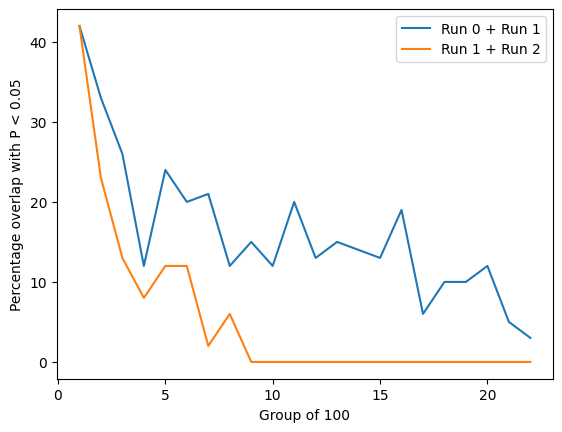

In [14]:
for i in range(comb_df.shape[1]-1):
    tdf = comb_df.iloc[:, :i+2].copy()
    tdf['agg_P'] = tdf.apply(lambda x: 10**np.mean(np.log10(x.values[:-1])), axis=1).values
    tdf = tdf[['agg_P', tdf.columns[-2]]]
    tdf = tdf.sort_values('agg_P')
    tdf = tdf < 0.05
    overlap = np.all(tdf.values, axis=1)
    overlap = np.array_split(overlap, np.arange(100, len(overlap), 100))
    overlap = np.array([np.count_nonzero(o) for o in overlap])
    sns.lineplot(x=np.arange(len(overlap))+1, y=overlap, label=f'Run {i} + Run {i+1}')
ax = plt.gca()
ax.set_xlabel('Group of 100')
ax.set_ylabel('Percentage overlap with P < 0.05')
plt.show()

In [85]:
comb_df['agg_P'] = comb_df.apply(lambda x: 10**np.mean(np.log10(x.values)), axis=1).values
# hit_genes1 = comb_df[comb_df['agg_P'] < 1e-6].index.to_list()
hit_genes1 = comb_df[comb_df['agg_P'] < (0.05/71000)].index.to_list()
# hit_genes1 = set(hit_genes1)
hit_genes1 = set([g.split('_')[0] for g in hit_genes1])
print(len(hit_genes1))

32


/tmp/ipykernel_18467/2773823011.py:1: RuntimeWarning: divide by zero encountered in log10
  comb_df['agg_P'] = comb_df.apply(lambda x: 10**np.mean(np.log10(x.values)), axis=1).values


### Run2

In [86]:
grp_sizes = [10]
tseeds = [4250, 8162, 918]
rseeds = [4250, 8162, 918]
metric = 'Loss'
greater_is_better = False
version = 'v4'

comb_df = None
for gs in grp_sizes:
    for tseed, rseed in zip(tseeds, rseeds):
        exp_name = f'Sens8_{tseed}{rseed}_GS{gs}_{version}'
        exp_folder = f'./results_{exp_name}'
        summ_df = pd.read_csv(f'{exp_folder}/FH_AD_{metric}_{exp_name}_summary.csv')
        summ_df[f'GS{gs}_{tseed}{rseed}_P'] = summ_df['P'].values
        summ_df = summ_df[['Gene', f'GS{gs}_{tseed}{rseed}_P']]
        if comb_df is None:
            comb_df = summ_df.loc[(summ_df[f'GS{gs}_{tseed}{rseed}_P'] < 0.05) | 
                                  (summ_df['Gene'].isin(['BIN1_0', 'BIN1_1', 'BIN1_2', 'BIN1_3', 'BIN1_4', 'BIN1_5']))]
        else:
            comb_df = pd.merge(comb_df, summ_df, left_on='Gene', right_on='Gene', 
                               how='outer')
comb_df.set_index('Gene', inplace=True)

/tmp/ipykernel_18467/2610388625.py:3: RuntimeWarning: divide by zero encountered in log10
  tdf['agg_P'] = tdf.apply(lambda x: 10**np.mean(np.log10(x.values[:-1])), axis=1).values
/tmp/ipykernel_18467/2610388625.py:3: RuntimeWarning: divide by zero encountered in log10
  tdf['agg_P'] = tdf.apply(lambda x: 10**np.mean(np.log10(x.values[:-1])), axis=1).values


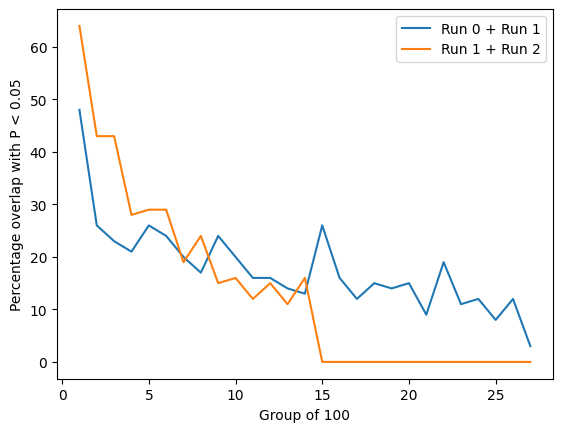

In [17]:
for i in range(comb_df.shape[1]-1):
    tdf = comb_df.iloc[:, :i+2].copy()
    tdf['agg_P'] = tdf.apply(lambda x: 10**np.mean(np.log10(x.values[:-1])), axis=1).values
    tdf = tdf[['agg_P', tdf.columns[-2]]]
    tdf = tdf.sort_values('agg_P')
    tdf = tdf < 0.05
    overlap = np.all(tdf.values, axis=1)
    overlap = np.array_split(overlap, np.arange(100, len(overlap), 100))
    overlap = np.array([np.count_nonzero(o) for o in overlap])
    sns.lineplot(x=np.arange(len(overlap))+1, y=overlap, label=f'Run {i} + Run {i+1}')
ax = plt.gca()
ax.set_xlabel('Group of 100')
ax.set_ylabel('Percentage overlap with P < 0.05')
plt.show()

In [87]:
comb_df['agg_P'] = comb_df.apply(lambda x: 10**np.mean(np.log10(x.values)), axis=1).values
# hit_genes2 = comb_df[comb_df['agg_P'] < 1e-6].index.to_list()
hit_genes2 = comb_df[comb_df['agg_P'] < (0.05/71000)].index.to_list()
# hit_genes2 = set(hit_genes2)
hit_genes2 = set([g.split('_')[0] for g in hit_genes2])
print(len(hit_genes2))

46


/tmp/ipykernel_18467/3267351003.py:1: RuntimeWarning: divide by zero encountered in log10
  comb_df['agg_P'] = comb_df.apply(lambda x: 10**np.mean(np.log10(x.values)), axis=1).values


### Run1 intersection Run2

0.3448275862068966

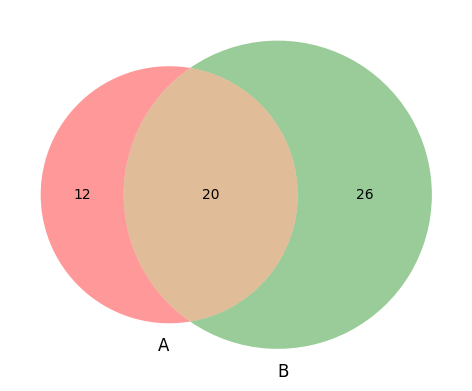

In [88]:
from matplotlib_venn import venn2
venn2([hit_genes1, hit_genes2])
i = hit_genes1.intersection(hit_genes2)
u = hit_genes1.union(hit_genes2)
len(i)/len(u)

In [89]:
hit_overlap = hit_genes1.intersection(hit_genes2)
with open('./params/reviewer_rerun_Sens8hit_overlap_2runs_.txt', 'w') as f:
    f.write('\n'.join(hit_overlap))

## Sens8 average over multiple runs

In [39]:
grp_sizes = [10]
tseeds = [0, 89, 937, 4250]
rseeds = [0, 89, 937, 4250]
metric = 'Loss'
greater_is_better = False
version = 'v4'

comb_df = None
for gs in grp_sizes:
    for tseed, rseed in zip(tseeds, rseeds):
        exp_name = f'Sens8_{tseed}{rseed}_GS{gs}_{version}'
        exp_folder = f'./results_{exp_name}'
        summ_df = pd.read_csv(f'{exp_folder}/FH_AD_{metric}_{exp_name}_summary.csv')
        summ_df[f'GS{gs}_{tseed}{rseed}_P'] = summ_df['P'].values
        
        if comb_df is None:
            comb_df = summ_df[['Gene', 'Chrom', f'GS{gs}_{tseed}{rseed}_P']]
        else:
            summ_df = summ_df[['Gene', f'GS{gs}_{tseed}{rseed}_P']]
            comb_df = pd.merge(comb_df, summ_df, left_on='Gene', right_on='Gene', 
                               how='outer') 

comb_df.set_index(['Gene', 'Chrom'], inplace=True)
comb_df['agg_P'] = comb_df.apply(lambda x: np.mean(np.log10(x)), axis=1).values
comb_df['agg_P'] = 10**comb_df['agg_P'].values
comb_df.head()

/home/upamanyu/.pyenv/versions/3.8.15/envs/GWANN/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,,GS10_00_P,GS10_8989_P,GS10_937937_P,GS10_42504250_P,agg_P
Gene,Chrom,,,,,
AADACL3_0,1.0,0.716268,0.820988,0.716315,0.936193,0.792448
ABCA4_6,1.0,0.423606,0.467773,0.301337,0.946804,0.487615
AADACL4_1,1.0,0.394355,0.301647,0.380737,0.429102,0.373373
ABCA4_5,1.0,0.431895,0.628691,0.280968,0.581701,0.458979
ABCA4_3,1.0,0.387946,0.390998,0.465197,0.854811,0.495579


In [53]:
_, corr_p, _, alpha_bonf = multipletests(comb_df['agg_P'].values, method='bonferroni')
print(f'Bonferroni threshold: {alpha_bonf}')

gene_comb_df = comb_df.copy()
gene_comb_df['adj_agg_P'] = corr_p
gene_comb_df.reset_index(inplace=True)

summ_df = gene_comb_df.copy()
summ_df.rename(columns={'adj_agg_P':'P_bonf', 'agg_P':'P'}, 
               inplace=True)
summ_df = summ_df[['Gene', 'Chrom', 'P', 'P_bonf']]
summ_df.head()
summ_df.to_csv('results_Sens8_v4_avg/FH_AD_Loss_Sens8_v4_avg_summary.csv', 
               index=False)


Bonferroni threshold: 7.05736224028907e-07


In [49]:
gene_comb_df['Gene'] = gene_comb_df['Gene'].apply(lambda x: x.split('_')[0]).values
gene_comb_df.sort_values(['Gene', 'adj_agg_P'], ascending=True, inplace=True)
gene_comb_df.drop_duplicates('Gene', inplace=True)
gene_comb_df.head()

,Win,Chrom,GS10_00_P,GS10_8989_P,GS10_937937_P,GS10_42504250_P,P,P_bonf
4816,RPS6KC1,1.0,1.447515e-19,1.735967e-20,1.999662e-16,0.003699,6.565916e-15,4.651820e-10
3105,LRRC7,1.0,2.174166e-10,2.474551e-28,2.688195e-02,0.000013,1.164558e-11,8.250662e-07
365,ATF6,1.0,7.626171e-14,9.966064e-01,1.545730e-12,0.998094,5.851724e-07,4.145830e-02
5140,SLC35A3,1.0,3.124823e-09,2.100523e-03,1.210813e-11,0.009355,9.285730e-07,6.578754e-02
4795,ROR1,1.0,4.460267e-20,9.112977e-03,8.456717e-01,0.008568,1.310032e-06,9.281314e-02


In [47]:
gene_comb_df.sort_values(['Chrom', 'adj_agg_P'], inplace=True)
gene_comb_df.loc[gene_comb_df['adj_agg_P'] < 0.05][['Chrom', 'Gene', 'agg_P', 'adj_agg_P']]

,Chrom,Gene,agg_P,adj_agg_P
4816,1.0,RPS6KC1,6.565916e-15,4.651820e-10
3105,1.0,LRRC7,1.164558e-11,8.250662e-07
365,1.0,ATF6,5.851724e-07,4.145830e-02
6942,2.0,BIN1,3.115674e-29,2.207392e-24
18213,4.0,EPHA5,4.494965e-15,3.184593e-10
30028,7.0,EPHA1,2.584755e-08,1.831247e-03
37494,9.0,LINGO2,1.364589e-10,9.667841e-06
38451,9.0,RECK,6.862043e-07,4.861620e-02
41438,10.0,NRG3,7.901193e-11,5.597837e-06
41705,10.0,PDSS1,3.050836e-09,2.161456e-04
